In [1]:
import pandas as pd
import sys
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
    
import os
wd = os.getcwd()
print (f'working directory: {wd}')

working directory: /home/jupyter/iST_Platform_Comparison/edit


In [2]:
gene_ordered_dict = {'xenium_panhuman_normal':['ABCC11','MYH11','ACTG2','CNN1','SMYD2',
                                               'UMOD','ADH4','CYP2B6','AGER','PPY',
                                               'SLC22A8','LY6D','MLANA','CD19',],
                    'merscope_breast_normal':['ABCC11', 'MUC6','APOC1',
                                              'HPX', 'RTKN2', 'ANKRD30A','OPRPN',
                                              'C5orf46', 'ADIPOQ', 'C15orf48','OXTR','CD19'],
                    'cosmx_multitissue_normal':['FABP4','ACTG2','MYH11', 'TCAP','FGF9',
                                                'TTR','FGG','APOA1','GC',
                                                'DMBT1','INS','SPP1','CALB1',
                                                'KRT10','KRT14','KRT1','LY6D',
                                                'CD5L','CD19'],
                                                }

In [3]:
def enrichment(sample, gene_ordered_dict):
    """Calculate specificity based on lineage markers
    """
    tissues = ['Breast', 'Colon', 'Heart', 'Kidney', 'Liver', 'Lung', 'Pancreas', 'Renal',
        'Skin', 'Spleen','Tonsil']

    gene_list = gene_ordered_dict[sample]
    print (len(gene_list), gene_list)

    print (f'sample: {sample}')
    df_t = pd.read_csv(f'{wd}/data/gene_level_csv/gene_level_csv_{sample}.csv')
    df_gene = df_t.loc[df_t['code_type']=='gene']
    df_gene = df_gene.drop('core', axis=1)
    df_gene_g = df_gene.groupby(['tissue_type','gene', 'code_type']).mean().reset_index().fillna(0)
    df_mat2 = df_gene_g.pivot(index = 'gene', columns = 'tissue_type', values = 'count')
    df_mat3 = df_mat2/df_mat2.sum()*10000 # ???

    df_mat4 = df_mat3.reset_index()
    df_mat4 = df_mat4.loc[df_mat4['gene'].isin(gene_list)]

    heat_map_data = df_mat4[['gene']]
    for t in df_mat4.columns:
        if t in tissues:
            heat_map_data[t] = df_mat4[t]

    heat_map_data = heat_map_data.set_index('gene').T.fillna(0)

    df = (heat_map_data-heat_map_data.mean())/heat_map_data.std()
    df_reordered = df[gene_ordered_dict[sample]]

    sns.set(style='white', rc={'figure.figsize': (10,10), 'figure.dpi': 250,})
    plt.figure(figsize=(12, 6))

    g = sns.heatmap(df_reordered, cmap='coolwarm',
                    linewidth=0.01, linecolor='white',
                    vmin=-0.5, vmax=3.0,
                    annot=False, cbar_kws={'label': 'Z-scored gene expression'})
    plt.title('Gene Expression Heatmap')
    plt.ylabel('')
    plt.xlabel('')
    plt.savefig(f'{wd}/figures/enrichment/enrichment_{sample}.png', bbox_inches='tight')
    plt.show()

    enrichment = (heat_map_data.max()/heat_map_data.median())
    enrichment.name = 'enrichment'
    enrichment.index.name = 'gene'
    enrichment.to_csv(f'{wd}/data/enrichment/{sample}_enrichment.csv', header=True)
    enrichment.head()

    return df_reordered

14 ['ABCC11', 'MYH11', 'ACTG2', 'CNN1', 'SMYD2', 'UMOD', 'ADH4', 'CYP2B6', 'AGER', 'PPY', 'SLC22A8', 'LY6D', 'MLANA', 'CD19']
sample: xenium_panhuman_normal


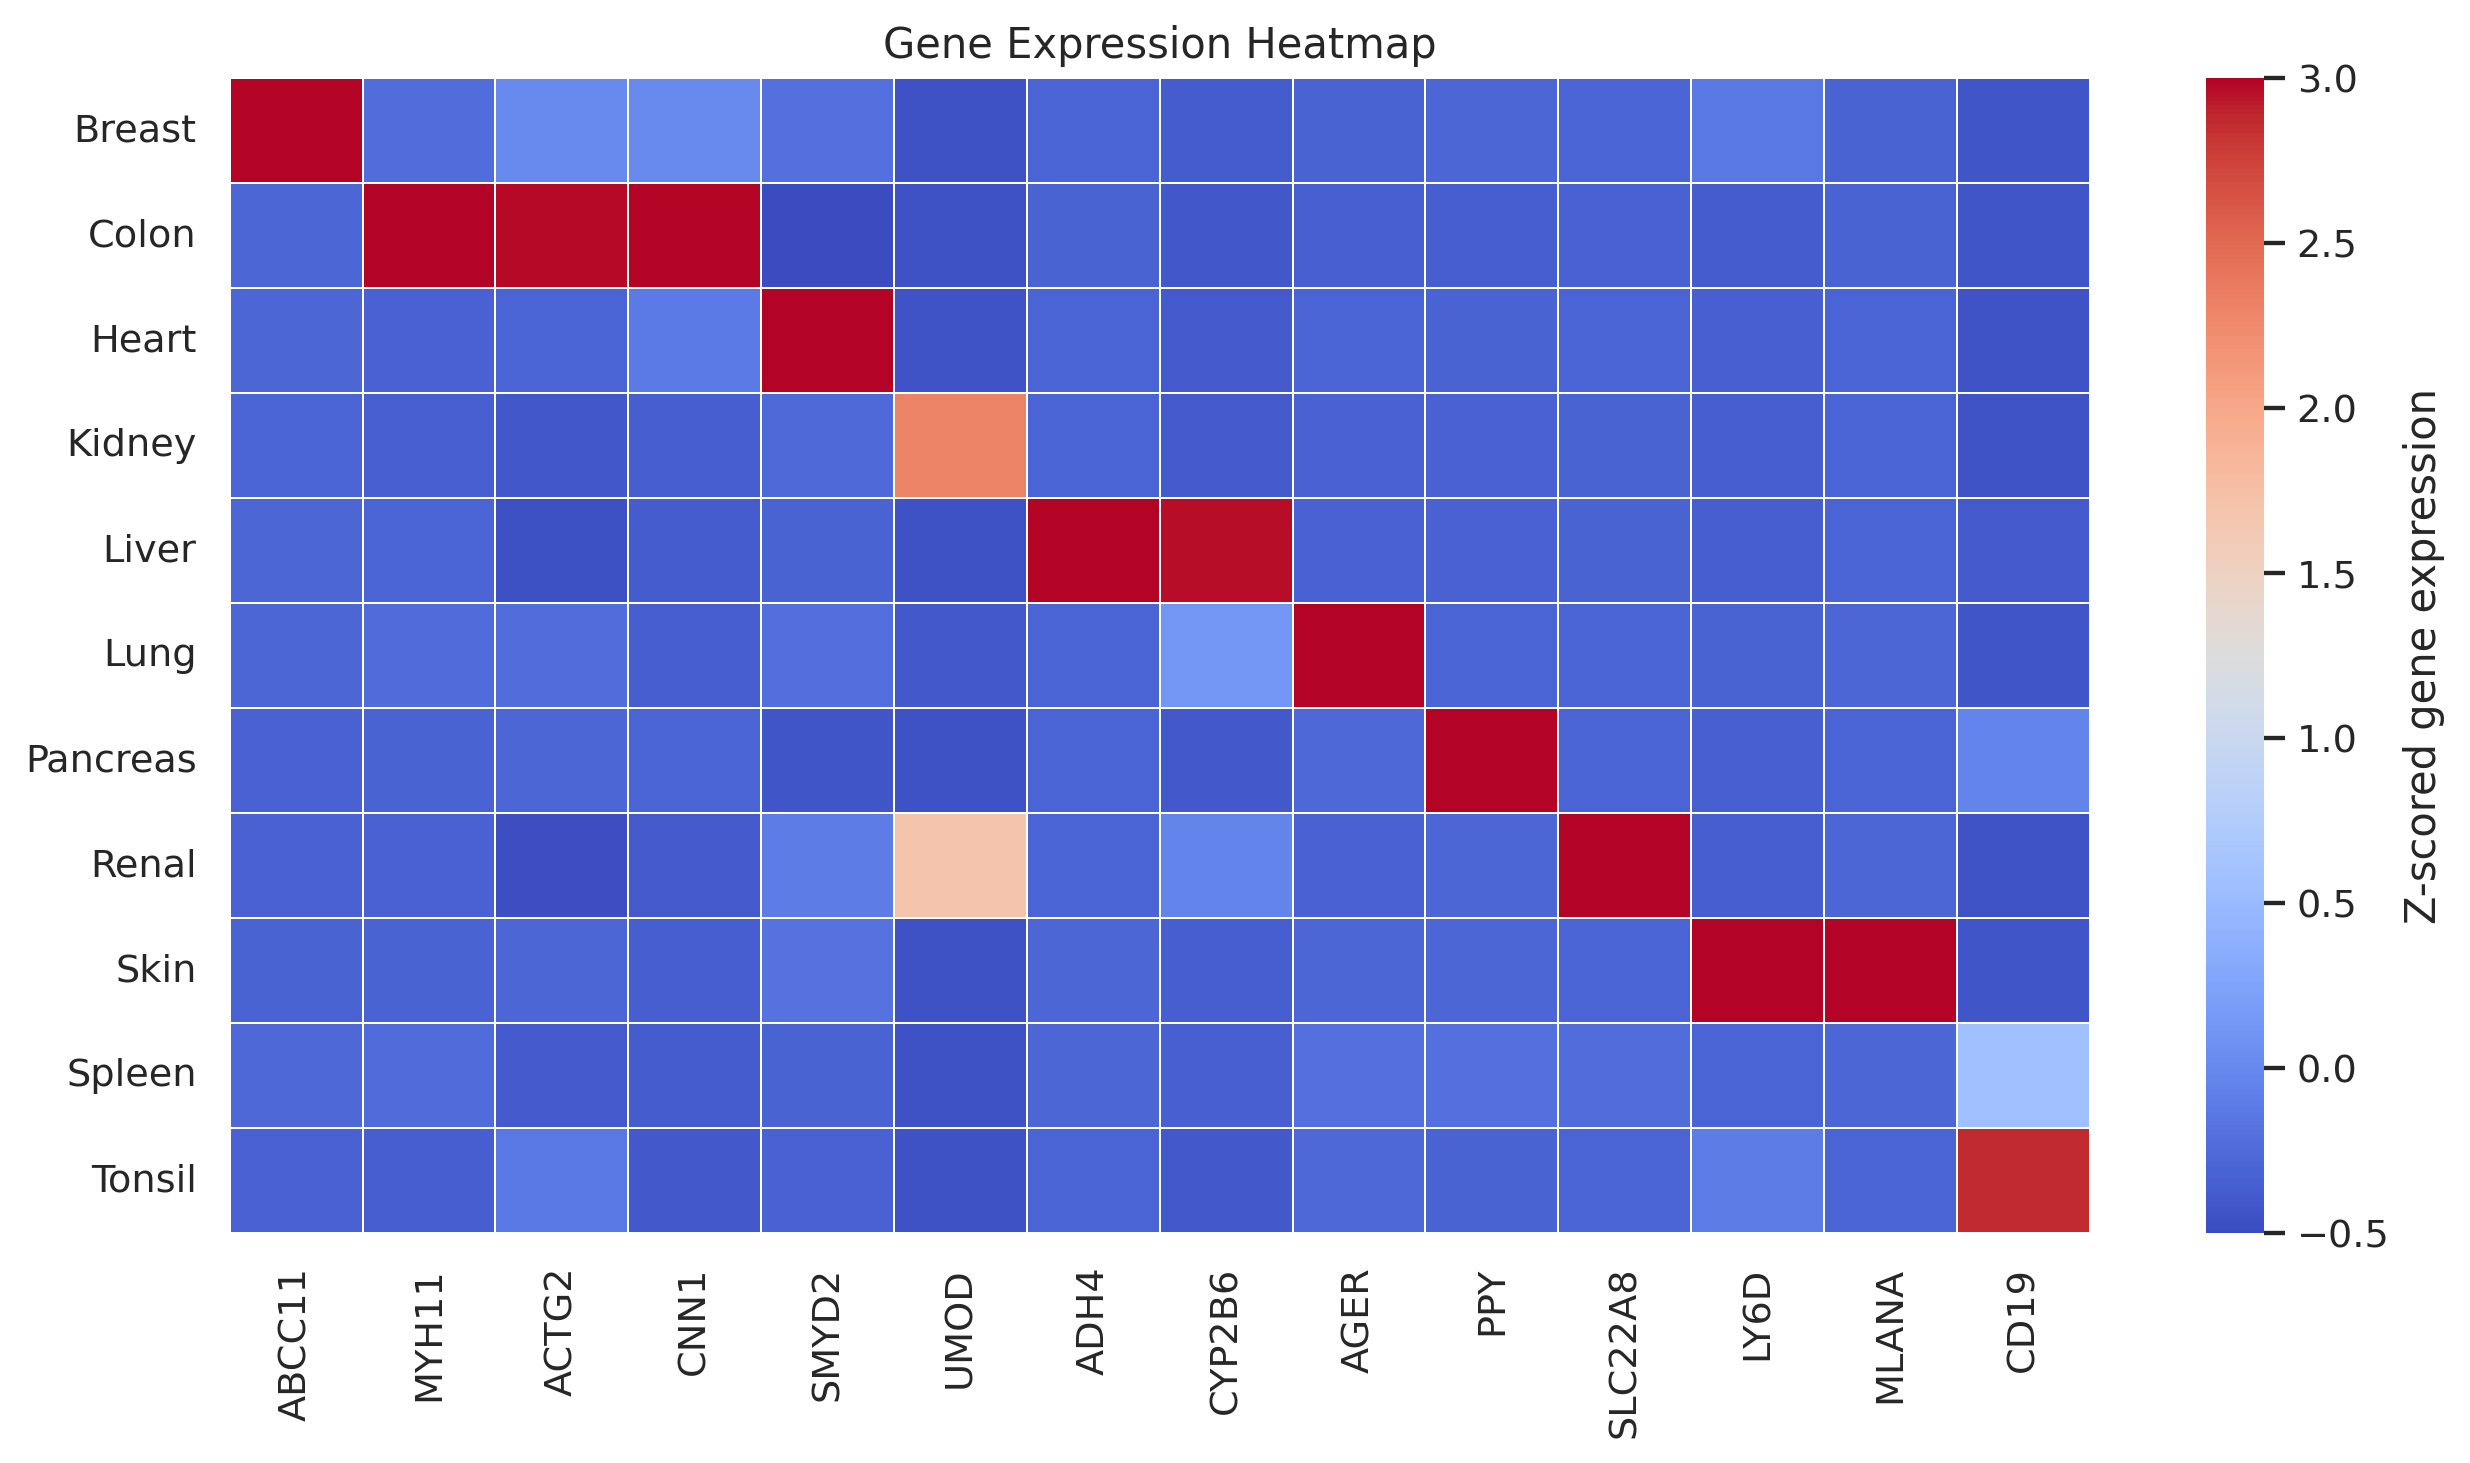

12 ['ABCC11', 'MUC6', 'APOC1', 'HPX', 'RTKN2', 'ANKRD30A', 'OPRPN', 'C5orf46', 'ADIPOQ', 'C15orf48', 'OXTR', 'CD19']
sample: merscope_breast_normal


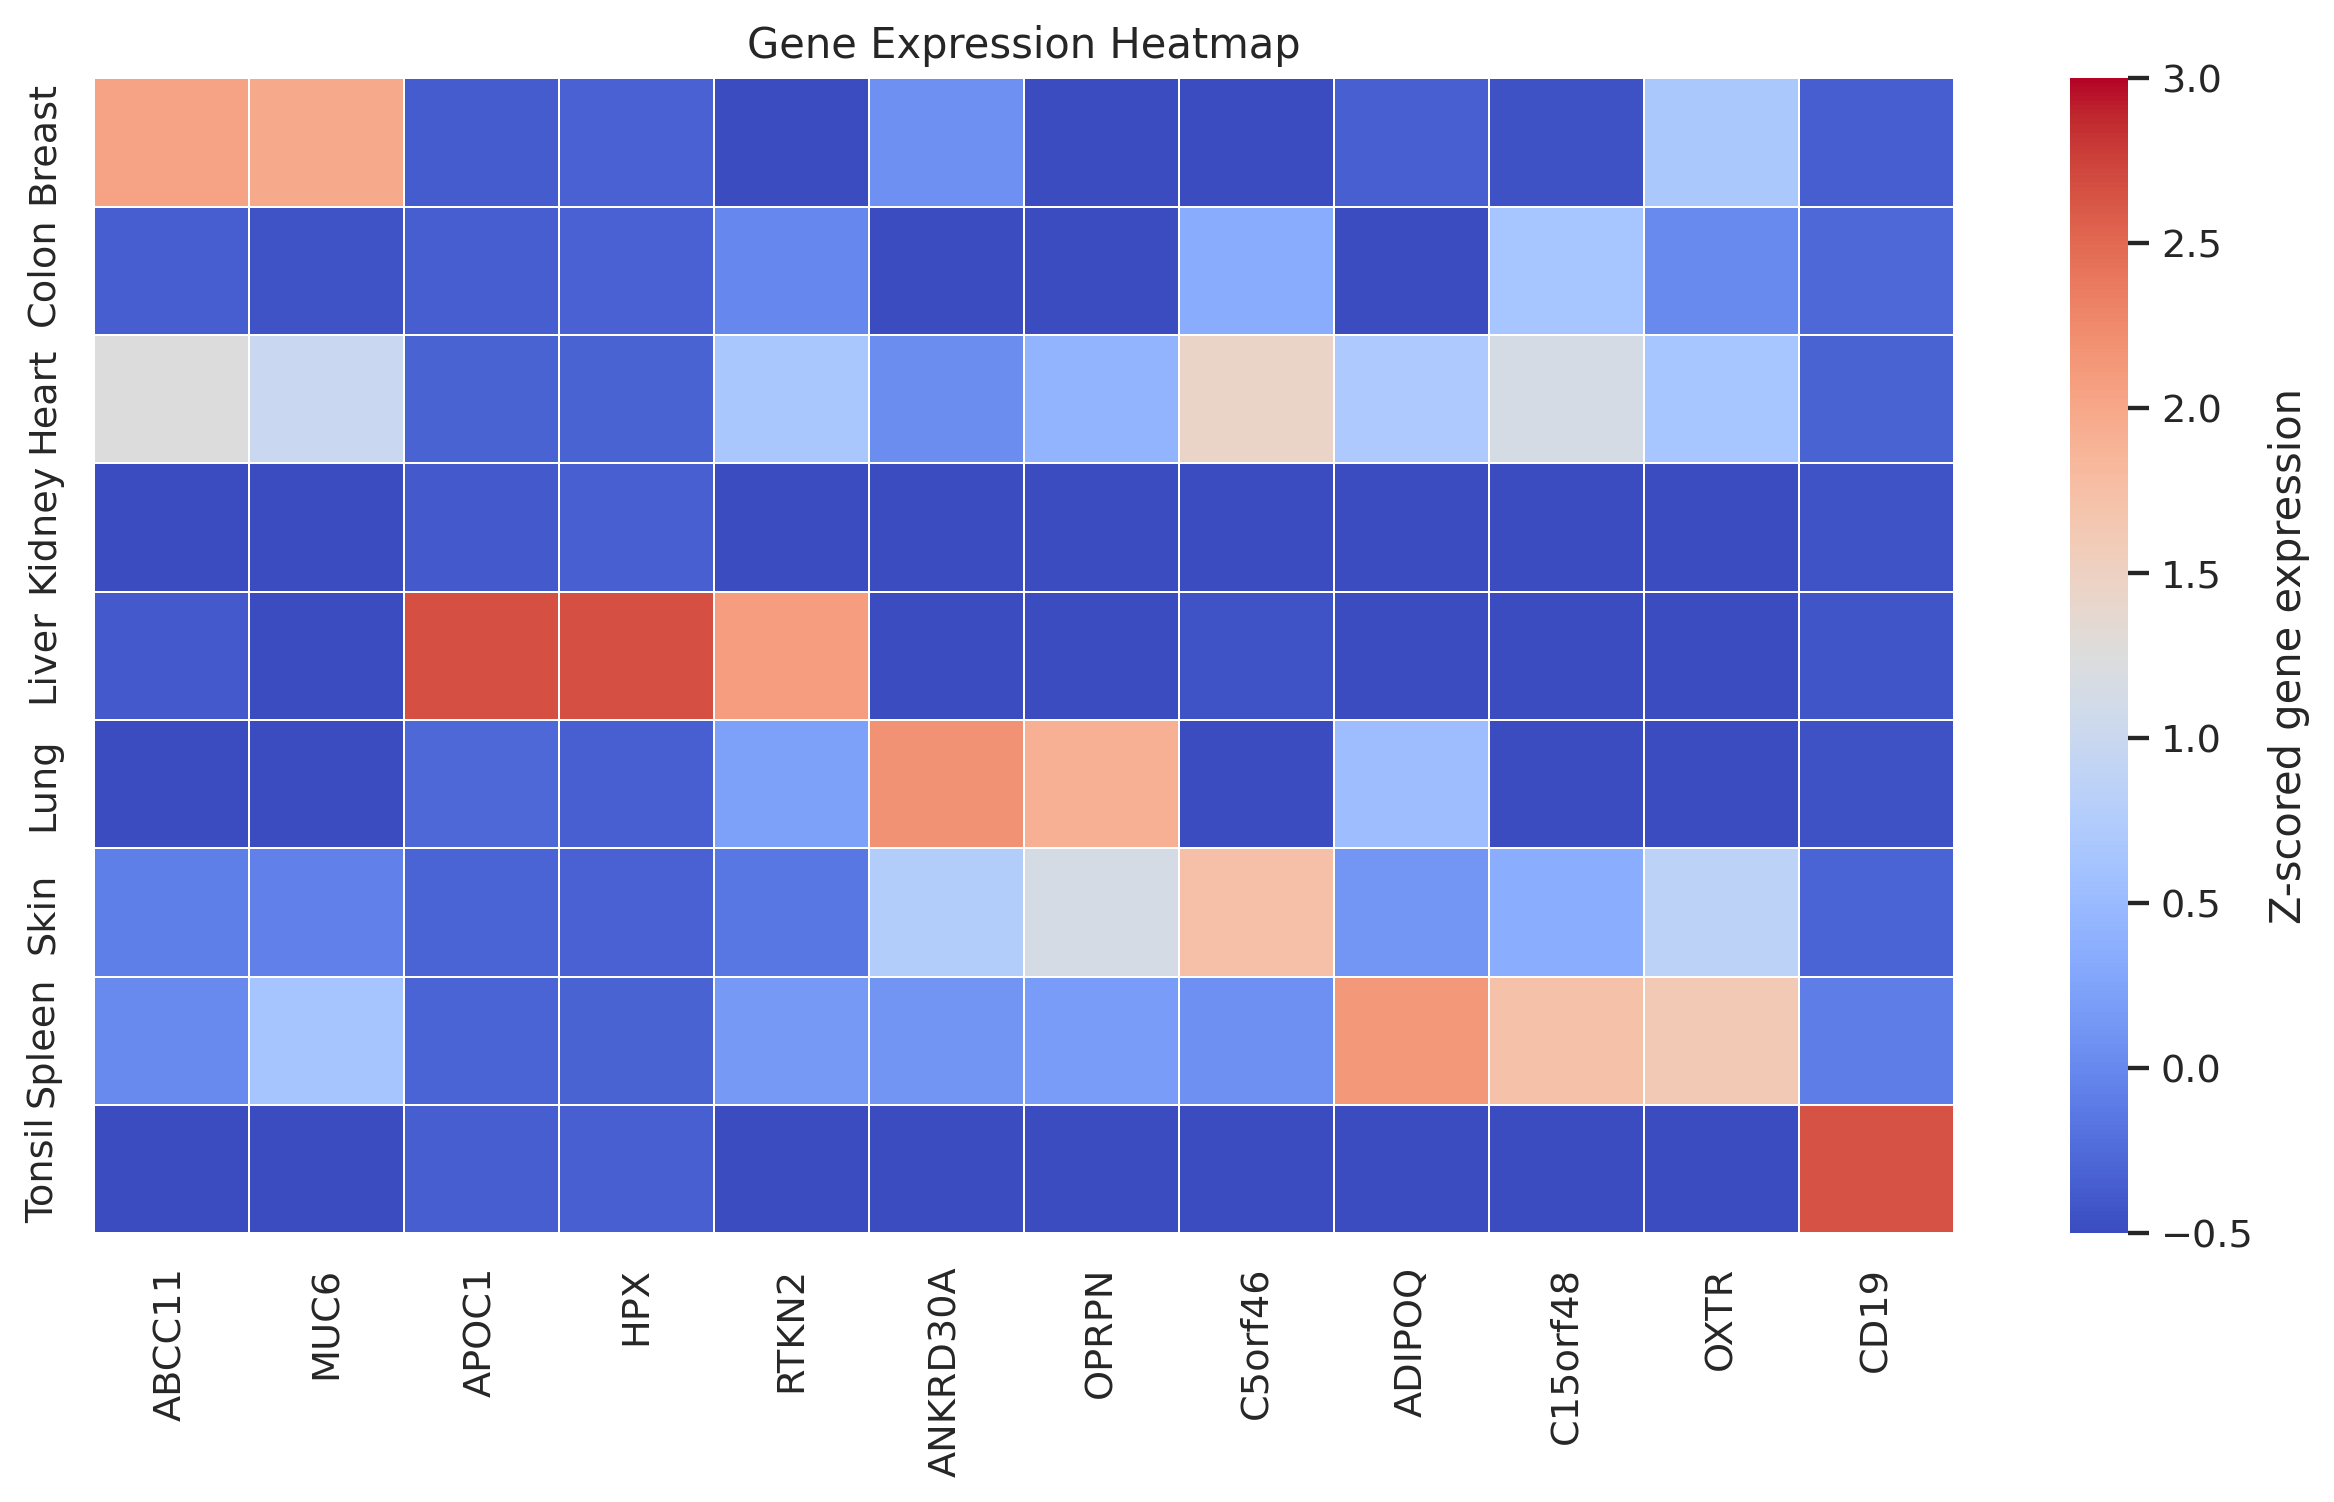

19 ['FABP4', 'ACTG2', 'MYH11', 'TCAP', 'FGF9', 'TTR', 'FGG', 'APOA1', 'GC', 'DMBT1', 'INS', 'SPP1', 'CALB1', 'KRT10', 'KRT14', 'KRT1', 'LY6D', 'CD5L', 'CD19']
sample: cosmx_multitissue_normal


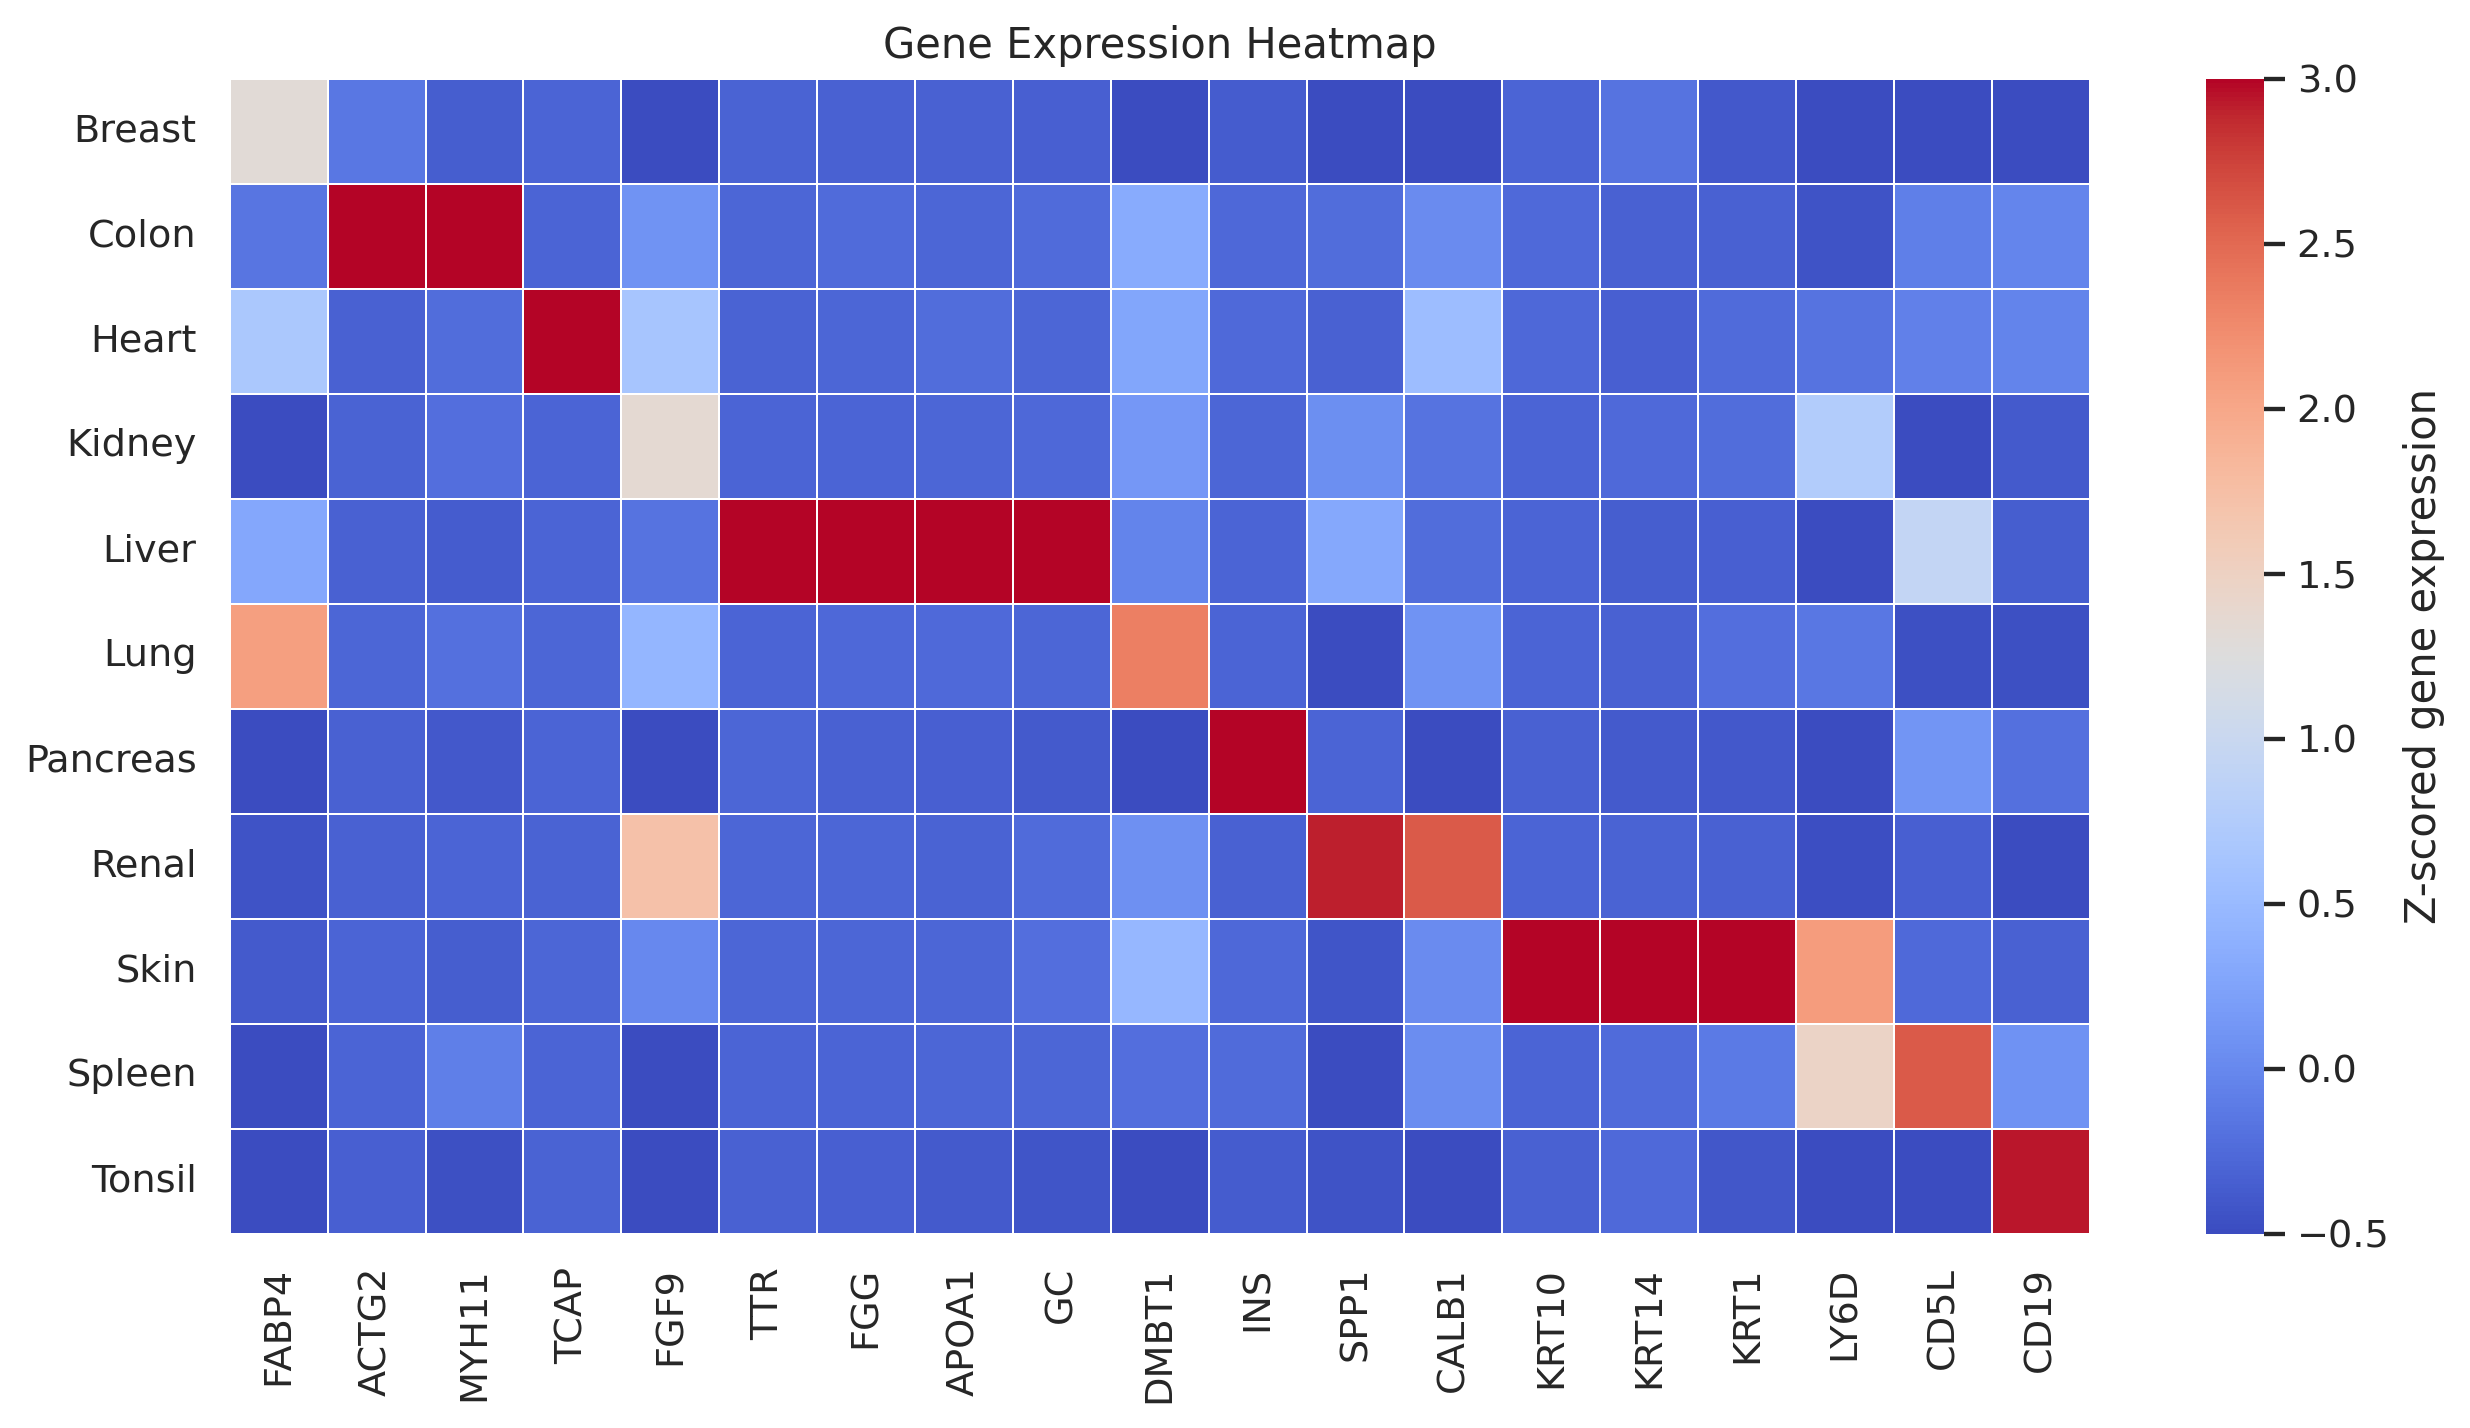

In [4]:
if not os.path.exists(f'{wd}/data/enrichment'):
    os.makedirs(f'{wd}/data/enrichment')
    
if not os.path.exists(f'{wd}/figures/enrichment'):
    os.makedirs(f'{wd}/figures/enrichment')


df_all = pd.DataFrame()
for sample in ['xenium_panhuman_normal', 'merscope_breast_normal','cosmx_multitissue_normal']:
    df = enrichment(sample, gene_ordered_dict).T
    df['order'] = range(len(df))
    df['sample'] = sample.split('_')[0]
    df_all = pd.concat([df_all, df])

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


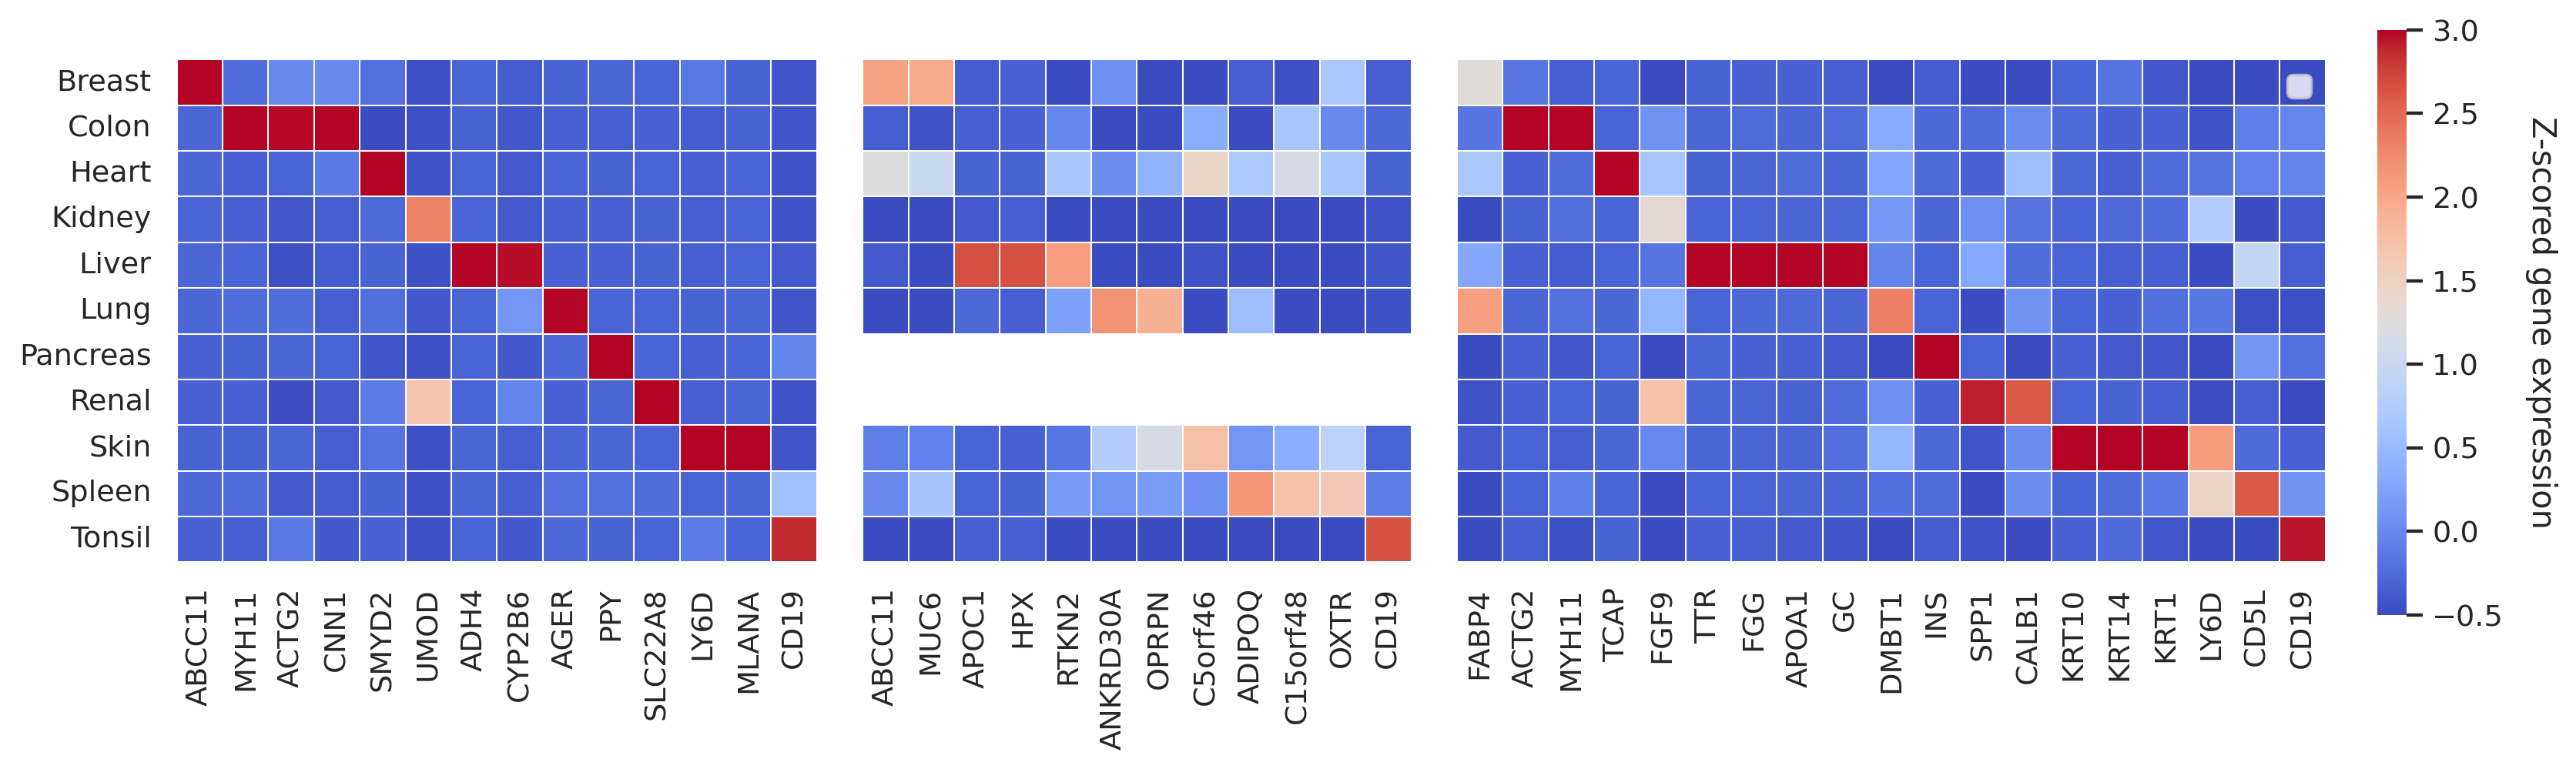

In [5]:
# Assuming df_all is already defined

# Transpose and preprocess the dataframe as per your code
df_plot = df_all.T
df_plot = df_plot.iloc[:-2]
df_plot = df_plot.astype('float')

# Insert the NaN columns for spacers at the specified positions
df_plot.insert(14, "spacer1", np.nan)
df_plot.insert(27, "spacer2", np.nan)

sns.set(style='white', rc={'figure.figsize': (18,4), 'figure.dpi': 250,})
g = sns.heatmap(df_plot, cmap='coolwarm',
                linewidth=0.01, linecolor='white',
                vmin=-0.5, vmax=3.0, square=True,
                annot=False, cbar_kws={'label': 'Z-scored gene expression'})

cbar = g.collections[0].colorbar
cbar.ax.set_position([0.76, 0.1, 0.1, 0.76])
cbar.set_label('Z-scored gene expression', rotation=270, labelpad=20)

# Get labels and modify them
labels = [item.get_text() for item in g.get_xticklabels()]
new_labels = ['' if label in ["spacer1", "spacer2"] else label for label in labels]
g.set_xticklabels(new_labels)

plt.legend()
plt.ylabel('')
plt.xlabel('')
plt.show()
